<a href="https://colab.research.google.com/github/Devi-Prasad-G/Drug_target_interaction/blob/main/drug_target_interaction_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

#creating embeddings

In [ ]:
def create_dataset(x1_embeds,x2,path):
  with open(path,'r') as f:
    x1_molecules = f.readlines()
  #print(len(x1_molecules),x1_molecules[0])
  x1_molecules = map(lambda s: s.strip(), x1_molecules) #removing \n from all strings
  x1 = []
  for i in x1_molecules:
    new_val = np.mean(x1_embeds[i],axis = 0)
    #print(new_val.shape)
    x1.append(new_val)
  return np.array(x1),np.squeeze(x2)

In [ ]:
train_x1_embeds = np.load("/content/drive/MyDrive/drug_target_interaction/compounds.npz")
train_x2 = np.load("/content/drive/MyDrive/drug_target_interaction/train_target.npy")
train_path = "/content/drive/MyDrive/drug_target_interaction/compounds.txt"
train_x1,train_x2 = create_dataset(train_x1_embeds,train_x2,train_path)
print(train_x1.shape,train_x2.shape)

(36592, 512) (36592, 1024)


In [ ]:
val_x1_embeds = np.load("/content/drive/MyDrive/drug_target_interaction/val_compounds.npz")
val_x2 = np.load("/content/drive/MyDrive/drug_target_interaction/val_target.npy")
val_path = "/content/drive/MyDrive/drug_target_interaction/val_compounds.txt"
val_x1,val_x2 = create_dataset(val_x1_embeds,val_x2,val_path)
print(val_x1.shape,val_x2.shape)

(5227, 512) (5227, 1024)


In [ ]:
test_x1_embeds = np.load("/content/drive/MyDrive/drug_target_interaction/test_compounds.npz")
test_x2 = np.load("/content/drive/MyDrive/drug_target_interaction/test_target.npy")
test_path = "/content/drive/MyDrive/drug_target_interaction/test_compounds.txt"
test_x1,test_x2 = create_dataset(test_x1_embeds,test_x2,test_path)
print(test_x1.shape,test_x2.shape)

(10455, 512) (10455, 1024)


In [ ]:
print(train_y[0:5])

[0.46 0.49 0.83 0.32 0.1 ]


#loading embeddings

In [ ]:
data = np.load("/content/drive/MyDrive/drug_target_interaction/data1.npy",allow_pickle = True)
train_x1,train_x2 = data[0]
val_x1,val_x2 = data[1]
test_x1,test_x2 = data[2]

In [ ]:
path =  "/content/drive/MyDrive/drug_target_interaction/"
train_y,val_y,test_y = np.load(path+"train_y.npy"),np.load(path+"val_y.npy"),np.load(path+"test_y.npy")

#baseline model

In [ ]:
import tensorflow as tf
import keras
from keras import Input
from keras import Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import concatenate
from keras import layers,models
from keras import regularizers

In [ ]:
def create_model(layers,units,reg):
  inputA = Input(shape=(512,))
  inputB = Input(shape=(1024,))

  combined = concatenate([inputA,inputB])

  z = Dense(units, activation="relu")(combined)
  for i in range(layers):
    if(reg):
      z = Dense(units,activation = "relu",kernel_regularizer=reg,bias_regularizer=reg)(z)
    else:
      z = Dense(units,activation = "relu")(z)

  z = Dense(1, activation="linear")(z)

  model = Model(inputs=[inputA, inputB], outputs=z)
  return model

In [ ]:
def plot_loss_curve(history):
  m = history.history
  plt.rcParams["figure.figsize"] = (8,6)
  epochs = list(range(1,101))
  plt.plot(epochs,m['loss'],'r',label = 'train_loss')
  plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
# layer = 0 with regularization
baseline_lay0_withr = create_model(0,1024,"l2")
print(baseline_lay0_withr.summary())
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
baseline_lay0_withr.compile(loss="mae", optimizer=opt)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/baseline_lay0_withr.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)

my_callbacks = [checkpoint]
history_baseline_lay0_withr = baseline_lay0_withr.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=100, batch_size=32,callbacks = my_callbacks)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1536)         0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         1573888     ['concatenate[0][0]']        

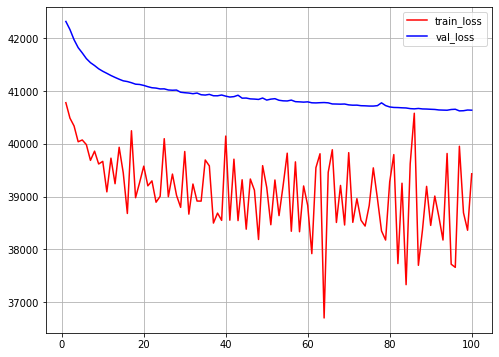

In [ ]:
plot_loss_curve(history_baseline_lay0_withr)

In [ ]:
#layers 0, layer 1 without regularization
baseline_lay1_noreg = create_model(1024)
print(baseline_lay1_noreg.summary())
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
baseline_lay1_noreg.compile(loss="mae", optimizer=opt)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/baseline_lay1_noreg.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)

my_callbacks = [checkpoint]
history_baseline_lay1_noreg = baseline_lay1_noreg.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=100, batch_size=32,callbacks = my_callbacks)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 1536)         0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_11 (Dense)               (None, 1024)         1573888     ['concatenate_4[0][0]']    

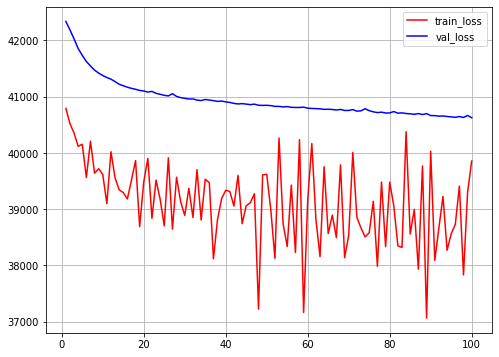

In [ ]:
plot_loss_curve(history_baseline_lay1_noreg)

In [ ]:
test_preds = baseline_lay0_withr.predict([test_x1,test_x2],batch_size = 1)

In [ ]:
print(test_preds[0])

[145.53896]


In [ ]:
#with regularization

baseline_lay1_withr = create_model(1024,"l2")
print(baseline_lay1_withr.summary())
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
baseline_lay1_withr.compile(loss="mae", optimizer=opt)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/baseline_lay1_withr.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)

my_callbacks = [checkpoint]
history_baseline_lay1_withr = baseline_lay1_withr.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=100, batch_size=32,callbacks = my_callbacks)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 1536)         0           ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 1024)         1573888     ['concatenate_5[0][0]']    

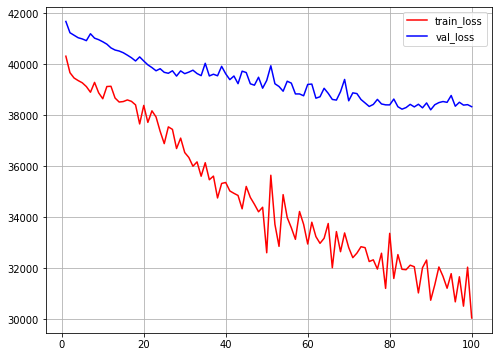

In [ ]:
plot_loss_curve(history_baseline_lay1_withr)

#baseline with mlp for each input

In [ ]:
inputA = Input(shape=(512,))
inputB = Input(shape=(1024,))

x = Dense(512, activation="relu")(inputA)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(128, activation='relu')(x)
x = Model(inputs=inputA, outputs=x)

y = Dense(512, activation="relu")(inputB)
y = Dense(512, activation="relu")(y)
y = Dense(512, activation="relu")(y)
y = Dense(128, activation="relu")(y)
y = Dense(128, activation='relu')(y)
y = Model(inputs=inputB, outputs=y)

combined = concatenate([x.output, y.output])

#z = Dense(16, activation="relu")(combined)
z = Dense(64, activation="relu")(combined)
z = Dense(64,activation = "relu")(z)
z = Dense(1, activation="linear")(z)

baseline_model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
baseline_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 512)          524800      ['input_4[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 512)          262656      ['input_3[0][0]']                
                                                                                            

In [ ]:
l = tf.keras.losses.MeanAbsolutePercentageError()
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
baseline_model.compile(loss=l, optimizer=opt)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/baseline1.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)
#tf.keras.callbacks.EarlyStopping(patience=5),
my_callbacks = [checkpoint]

In [ ]:
history_baseline1 = baseline_model.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=75, batch_size=32,callbacks = my_callbacks)

Epoch 1/75
1143/1143 [==============================] - 21s 17ms/step - loss: 11923.8193 - val_loss: 110.8762
Epoch 2/75
1143/1143 [==============================] - 20s 17ms/step - loss: 12829.9834 - val_loss: 117.5116
Epoch 3/75
1143/1143 [==============================] - 20s 18ms/step - loss: 47642.8867 - val_loss: 119.8161
Epoch 4/75
1143/1143 [==============================] - 19s 16ms/step - loss: 13593.0254 - val_loss: 122.4686
Epoch 5/75
1143/1143 [==============================] - 19s 16ms/step - loss: 4570.4365 - val_loss: 119.8405
Epoch 6/75
1143/1143 [==============================] - 19s 17ms/step - loss: 243893.7500 - val_loss: 186.6952
Epoch 7/75
1143/1143 [==============================] - 19s 16ms/step - loss: 27602.9336 - val_loss: 570.8495
Epoch 8/75
1143/1143 [==============================] - 19s 16ms/step - loss: 464939.0625 - val_loss: 129.6332
Epoch 9/75
1143/1143 [==============================] - 19s 17ms/step - loss: 9115.9834 - val_loss: 198.4215
Epoch 10/7

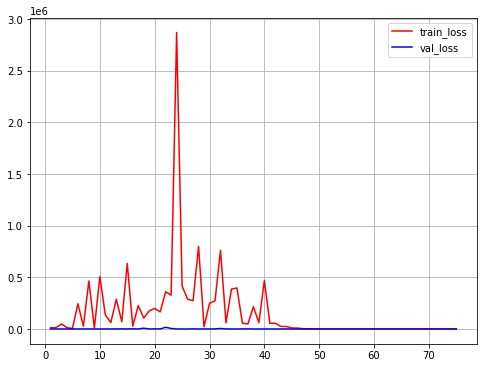

In [ ]:
from matplotlib import pyplot as plt
m = history_baseline1.history
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,76))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
history_baseline = baseline_model.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=75, batch_size=32,callbacks = my_callbacks)

Epoch 1/75
1143/1143 [==============================] - 11s 7ms/step - loss: 6351.6240 - val_loss: 114.7737
Epoch 2/75
1143/1143 [==============================] - 5s 4ms/step - loss: 79055.1797 - val_loss: 140.3832
Epoch 3/75
1143/1143 [==============================] - 5s 4ms/step - loss: 5220.1021 - val_loss: 150.9302
Epoch 4/75
1143/1143 [==============================] - 5s 4ms/step - loss: 14433.3301 - val_loss: 182.3148
Epoch 5/75
1143/1143 [==============================] - 6s 5ms/step - loss: 19660.6562 - val_loss: 108.9186
Epoch 6/75
1143/1143 [==============================] - 5s 4ms/step - loss: 56438.9102 - val_loss: 140.7695
Epoch 7/75
1143/1143 [==============================] - 5s 4ms/step - loss: 38717.8516 - val_loss: 151.1125
Epoch 8/75
1143/1143 [==============================] - 5s 4ms/step - loss: 21876.1191 - val_loss: 113.2594
Epoch 9/75
1143/1143 [==============================] - 5s 4ms/step - loss: 123928.6094 - val_loss: 148.4102
Epoch 10/75
1143/1143 [=====

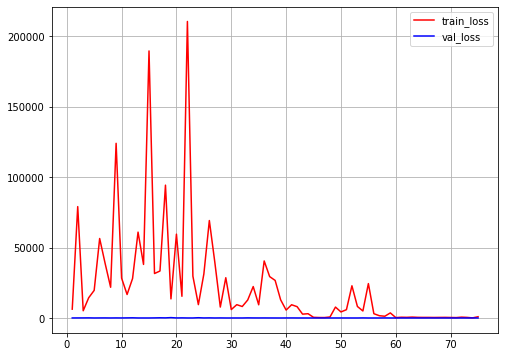

In [ ]:
from matplotlib import pyplot as plt
m = history_baseline.history
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,76))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
history_baseline = baseline_model.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=75, batch_size=32,callbacks = my_callbacks)

Epoch 1/500
1143/1143 [==============================] - 9s 5ms/step - loss: 34986.3984 - val_loss: 122.4374
Epoch 2/500
1143/1143 [==============================] - 5s 4ms/step - loss: 147117.7031 - val_loss: 129.9161
Epoch 3/500
1143/1143 [==============================] - 5s 4ms/step - loss: 203060.3125 - val_loss: 156.5922
Epoch 4/500
1143/1143 [==============================] - 6s 5ms/step - loss: 169374.3438 - val_loss: 106.3024
Epoch 5/500
1143/1143 [==============================] - 6s 5ms/step - loss: 41792.2617 - val_loss: 108.4247
Epoch 6/500
1143/1143 [==============================] - 5s 4ms/step - loss: 35621.7812 - val_loss: 117.7623
Epoch 7/500
1143/1143 [==============================] - 5s 4ms/step - loss: 8511.3242 - val_loss: 113.8531
Epoch 8/500
1143/1143 [==============================] - 5s 4ms/step - loss: 35554.7305 - val_loss: 203.5267
Epoch 9/500
1143/1143 [==============================] - 5s 4ms/step - loss: 151925.5000 - val_loss: 116.2477
Epoch 10/500
114

KeyboardInterrupt: ignored

In [ ]:
history_baseline = baseline_model.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=500, batch_size=32,callbacks = my_callbacks)

Epoch 1/500
1143/1143 [==============================] - 10s 5ms/step - loss: 16875.3887 - val_loss: 119.6096
Epoch 2/500
1143/1143 [==============================] - 5s 4ms/step - loss: 13092.9385 - val_loss: 104.2218
Epoch 3/500
1143/1143 [==============================] - 5s 4ms/step - loss: 11011.9639 - val_loss: 100.2156
Epoch 4/500
1143/1143 [==============================] - 5s 4ms/step - loss: 9262.0508 - val_loss: 101.7528
Epoch 5/500
1143/1143 [==============================] - 5s 4ms/step - loss: 10404.5186 - val_loss: 104.0702
Epoch 6/500
1143/1143 [==============================] - 5s 4ms/step - loss: 9411.3193 - val_loss: 101.8306
Epoch 7/500
1143/1143 [==============================] - 5s 4ms/step - loss: 10870.9688 - val_loss: 102.5332
Epoch 8/500
1143/1143 [==============================] - 5s 4ms/step - loss: 9582.5137 - val_loss: 102.3187
Epoch 9/500
1143/1143 [==============================] - 5s 5ms/step - loss: 10204.8750 - val_loss: 100.9471
Epoch 10/500
1143/114

KeyboardInterrupt: ignored

In [ ]:
np.save("/content/drive/MyDrive/drug_target_interaction/",np.array(history_baseline))

In [ ]:
#different version with less number of hidden layers.
history_baseline = baseline_model.fit( x=[train_x1, train_x2], y=train_y, validation_data=([val_x1, val_x2], val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=500, batch_size=32,callbacks = my_callbacks)

Epoch 1/500
1143/1143 [==============================] - 8s 4ms/step - loss: 48836.8867 - val_loss: 165.1773
Epoch 2/500
1143/1143 [==============================] - 4s 3ms/step - loss: 28997.3223 - val_loss: 124.5048
Epoch 3/500
1143/1143 [==============================] - 4s 3ms/step - loss: 25958.8398 - val_loss: 147.6406
Epoch 4/500
1143/1143 [==============================] - 4s 3ms/step - loss: 39799.8438 - val_loss: 125.5573
Epoch 5/500
1143/1143 [==============================] - 5s 4ms/step - loss: 13143.0283 - val_loss: 108.0518
Epoch 6/500
1143/1143 [==============================] - 4s 3ms/step - loss: 10278.1143 - val_loss: 111.2680
Epoch 7/500
1143/1143 [==============================] - 5s 4ms/step - loss: 11048.1494 - val_loss: 105.4998
Epoch 8/500
1143/1143 [==============================] - 4s 3ms/step - loss: 10271.2314 - val_loss: 100.2602
Epoch 9/500
1143/1143 [==============================] - 4s 3ms/step - loss: 7084.9868 - val_loss: 100.5844
Epoch 10/500
1143/11

In [ ]:
#history = new_model.fit(training_set_cropped, validation_data = validation_set_cropped, epochs=90,steps_per_epoch=training_set.samples//32,validation_steps=validation_set.samples //32,verbose=1,callbacks = [callback_lr,checkpoint])

#cca dataset

In [ ]:
new_data = np.load("/content/drive/MyDrive/drug_target_interaction/new_data.npy",allow_pickle = True)

In [ ]:
new_train_x1,new_train_x2,new_train_y = new_data[0][0],new_data[0][1], new_data[0][2]
new_val_x1,new_val_x2,new_val_y = new_data[1][0],new_data[1][1], new_data[1][2]
new_test_x1,new_test_x2,new_test_y = new_data[2][0],new_data[2][1], new_data[2][2]

In [ ]:
print(new_train_x1.shape,new_train_x2.shape,new_val_x1.shape,new_val_x2.shape,new_test_x1.shape,new_test_x2.shape)

(36592, 64) (36592, 64) (5227, 64) (5227, 64) (10455, 64) (10455, 64)


In [ ]:
import tensorflow as tf
import keras
from keras import Input
from keras import Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import concatenate
from keras import layers,models
from keras import regularizers

In [ ]:
def create_model(units):
  inputA = Input(shape=(64,))
  inputB = Input(shape=(64,))

  combined = concatenate([inputA,inputB])

  z = Dense(units, activation="relu")(combined)
  z = Dense(1, activation="sigmoid")(z)

  model = Model(inputs=[inputA, inputB], outputs=z)
  return model

In [ ]:
def plot_loss_curve(history):
  m = history.history
  plt.rcParams["figure.figsize"] = (8,6)
  epochs = list(range(1,101))
  plt.plot(epochs,m['loss'],'r',label = 'train_loss')
  plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
# with no layers
deep_cca_model = create_model(0)
print(deep_cca_model.summary())
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
deep_cca_model.compile(loss="mae", optimizer=opt)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/deep_cca_model.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)

my_callbacks = [checkpoint]
history_deep_cca = deep_cca_model.fit( x=[new_train_x1, new_train_x2], y=new_train_y, validation_data=([new_val_x1, new_val_x2], new_val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=100, batch_size=32,callbacks = my_callbacks)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1)            129         ['concatenate[0][0]']        

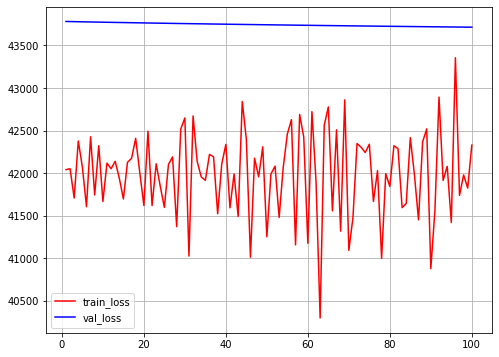

In [ ]:
plot_loss_curve(history_deep_cca)

In [ ]:
#with 1 layer
deep_cca_model1 = create_model(128)
print(deep_cca_model1.summary())
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
deep_cca_model1.compile(loss="mae", optimizer=opt)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/deep_cca_model1.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)

my_callbacks = [checkpoint]
history_deep_cca1 = deep_cca_model1.fit( x=[new_train_x1, new_train_x2], y=new_train_y, validation_data=([new_val_x1, new_val_x2], new_val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=100, batch_size=32,callbacks = my_callbacks)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128)          0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['concatenate_1[0][0]']    

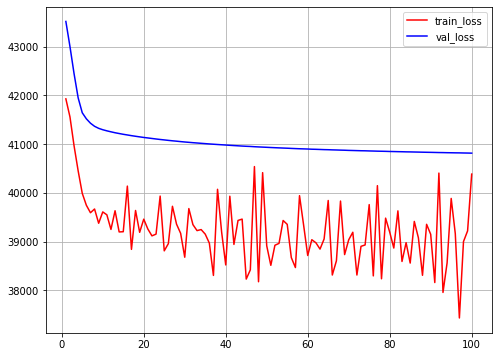

In [ ]:
plot_loss_curve(history_deep_cca1)

In [ ]:
test_loss = deep_cca_model1.predict([new_test_x1,new_test_x2],batch_size=1)

In [ ]:
tf.math.sum(test_loss)

In [ ]:
#with 1 layer
deep_cca_model2 = create_model(128)
print(deep_cca_model2.summary())
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3,decay=1e-3 / 200)
deep_cca_model2.compile(loss="mae", optimizer=opt)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/drug_target_interaction/deep_cca_model2.h5",
    monitor='val_loss',
    mode = 'min',
    save_best_only=True)

my_callbacks = [checkpoint]
history_deep_cca2 = deep_cca_model2.fit( x=[new_train_x1, new_train_x2], y=new_train_y, validation_data=([new_val_x1, new_val_x2], new_val_y), steps_per_epoch=36592//32, validation_steps=5227//32, verbose = 1, epochs=100, batch_size=32,callbacks = my_callbacks)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128)          0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          16512       ['concatenate_2[0][0]']    

#Extras

In [ ]:
print(len(train_x1_embeds.keys()))
print(train_x2.shape)

8387
(36592, 1, 1024)


In [ ]:
with open("/content/drive/MyDrive/drug_target_interaction/compounds.txt",'r') as f:
  train_x1_molecules = f.readlines()
print(len(train_x1_molecules),train_x1_molecules[0])

36592 Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1



In [ ]:
train_x1_molecules = map(lambda s: s.strip(), train_x1_molecules) #removing \n from all strings

In [ ]:
train_x1 = []
for i in train_x1_molecules:
  new_val = np.mean(train_x1_embeds[i],axis = 0)
  #print(new_val.shape)
  train_x1.append(new_val)

In [ ]:
train_x1 = np.array(train_x1)
print(train_x1.shape) #molecule embeddings 

(36589, 512)


In [ ]:
train_x2 = np.squeeze(train_x2)
print(train_x2.shape) #target embeddings

(36592, 1024)
